In [2]:
import argparse
import datetime
import os
import re
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")

import numpy as np
import tensorflow as tf

from energy_loss import *

print("IF GPU IS AVAILABLE, THIS WILL NOT BE EMPTY")
print(tf.config.list_physical_devices("GPU"))

IF GPU IS AVAILABLE, THIS WILL NOT BE EMPTY
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Parser for all arguments
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", default=32, type=int, help="Batch size.") # None
parser.add_argument("--epochs", default=1200, type=int, help="Number of epochs.") # None
parser.add_argument("--kl_weight", default=0.0008, type=float, help="Multiplier of the kl loss.")
parser.add_argument("--latent_size", default=500, type=int, help="Size of the latent layer.")
parser.add_argument("--eloss_weight", default=10**(-5), type=float, help="Multiplier of the energy loss at the beginning.")
parser.add_argument("--seed", default=42, type=int, help="Random seed.")
parser.add_argument("--threads", default=1, type=int, help="Maximum number of threads to use.")
args = parser.parse_args("") # that "" is needed for jupyter notebooks

NAME = "{}-{}-{}".format(
    os.path.basename(globals().get("__file__", "notebook")), # pokud chces pridat toto, pridej {}- pred to {}-{}
    os.environ.get("SLURM_JOB_ID", datetime.datetime.now().strftime("%Y-%m-%d_%H%M")),
    ",".join(("{}={}".format(re.sub("(.)[^_]*_?", r"\1", k), v) for k, v in sorted(vars(args).items()))))

RUN_INDEX = "03_vae_xyz_MSE_eloss_increase"

args.logdir = os.path.join("logs", NAME + "-" + RUN_INDEX)
args.modeldir = os.path.join("models", NAME + "-" + RUN_INDEX)

print(args.logdir)
print(args.modeldir)

logs/notebook-2023-07-18_1440-bs=32,ew=1e-05,e=1200,kw=0.0008,ls=500,s=42,t=1-03_vae_xyz_MSE_eloss_increase
models/notebook-2023-07-18_1440-bs=32,ew=1e-05,e=1200,kw=0.0008,ls=500,s=42,t=1-03_vae_xyz_MSE_eloss_increase


In [4]:
# Let's define how to get magnetic moments for that xyz MSE
pi = tf.constant(np.pi)

def get_angles(y):
    """Get tensors of angles theta and phi."""

    theta = y[:,:,:,0] * pi
    phi   = y[:,:,:,1] * (2. * pi)
        
    # return two tensors (batch_size, 200, 200)
    return theta, phi
    
def get_cartesian(theta, phi):
    """Get unit vector cartesian components."""
        
    # return tensor (batch_size, 200, 200, 3)
    return tf.stack([
        tf.math.cos(phi) * tf.math.sin(theta),
        tf.math.sin(phi) * tf.math.sin(theta),
        tf.math.cos(theta)
    ], axis=3)
    
def get_magnetic_moments(y):
    """Get tensor containing cartesian components of the magnetic moments."""
                
    # return tensor (batch_size, 200, 200, 3)
    return get_cartesian(*get_angles(y))

In [5]:
# Preparing the dataset
DATAFILE_1 = "/mnt/hdddata/dusek/datasetMC_2ch.npz"
DATAFILE_2 = "/mnt/hdddata/dusek/datasetMC_2ch_train.npz"

Xs, Vs, Ps = [], [], []
for file in [DATAFILE_1, DATAFILE_2]:
    Data = np.load(file)
    Xs.append(np.transpose(Data["data"].astype(np.float32), [0, 2, 3, 1]))
    Vs.append(Data["values"].astype(np.float32))
    Ps.append(Data["properties"].astype(np.float32))
X = np.concatenate(Xs, axis=0)
V = np.concatenate(Vs, axis=0)
P = np.concatenate(Ps, axis=0)

# Let's filter out non-skyrmion lattices (Q < value, where Q is a topological charge)
X_filtered = X[np.logical_and(P[:, 1] < -300, P[:, 0] > 0.399)]
V_filtered = V[np.logical_and(P[:, 1] < -300, P[:, 0] > 0.399)]
P_filtered = P[np.logical_and(P[:, 1] < -300, P[:, 0] > 0.399)]

# Augmentation
def generate_new_data(DT, DP, DV, num=1000):
    """Data augmentation. Generate new data from the dataset."""
    
    DTN, DPN, DVN = [], [], []
    for _ in range(num):
        # select random configuration
        ind = np.random.randint(len(DT))
        A = np.copy(DT[ind])
        
        # rotation
        k = np.random.randint(4)
        if (k != 0):
            A = np.rot90(A, k=k)
            A[:,:,1]  -= k*.25
            A[A < 0.] += 1.
                
        # shift
        rx, ry = np.random.randint(200, size=2)
        A = np.roll(A, shift=rx, axis=1)
        A = np.roll(A, shift=ry, axis=0)
        
        # append new data to arrays
        DTN.append(A)
        DPN.append(DP[ind])
        DVN.append(DV[ind])
        
    return np.array(DTN), np.array(DPN), np.array(DVN)


X_new, P_new, V_new = generate_new_data(X_filtered, P_filtered, V_filtered, num=2000)

X_final = np.concatenate([X_filtered, X_new], axis=0)
V_final = np.concatenate([V_filtered, V_new], axis=0)
P_final = np.concatenate([P_filtered, P_new], axis=0)
print("The augmented dataset shape is", X_final.shape)

# Now let's transform Theta, Phi into x, y, z lattices
X_final = get_magnetic_moments(X_final)
X_final = np.array(X_final) # 

# I would like to use sigmoid activation function, so X, which is in range (-1, 1) must be in range (0, 1)
# X_final = (X_final + 1) / 2

# Instead of the train_test_split tool
permutation = np.random.RandomState(42).permutation(len(X_final))
X_final = X_final[permutation]
V_final = V_final[permutation]
P_final = P_final[permutation]

X_train, X_val = X_final[:-len(X_final) // 10], X_final[-len(X_final) // 10:]
V_train, V_val = V_final[:-len(V_final) // 10], V_final[-len(V_final) // 10:]
P_train, P_val = P_final[:-len(P_final) // 10], P_final[-len(P_final) // 10:]

print("X_train shape is", X_train.shape)
print("min X", np.round(np.min(X_train[:, :, :, 0]), 2))
print("max X", np.round(np.max(X_train[:, :, :, 0]), 2))
print("min Y", np.round(np.min(X_train[:, :, :, 1]), 2))
print("max Y", np.round(np.max(X_train[:, :, :, 1]), 2))
print("min Z", np.round(np.min(X_train[:, :, :, 2]), 2))
print("max Z", np.round(np.max(X_train[:, :, :, 2]), 2))

The augmented dataset shape is (2860, 200, 200, 2)
X_train shape is (2574, 200, 200, 3)
min X -1.0
max X 1.0
min Y -1.0
max Y 1.0
min Z -1.0
max Z 1.0


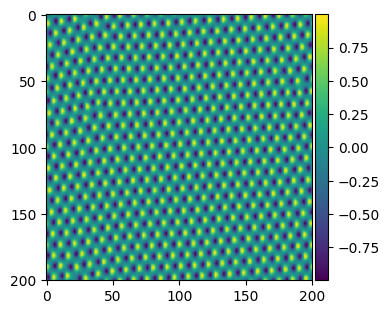

In [6]:
import matplotlib.pyplot as plt

image_example = X_final[25, :, :, 0]
fig, ax = plt.subplots(figsize=(4,4))
I = plt.imshow(image_example)
cbar=fig.colorbar(I,fraction=0.0472, pad=0.01)
ax.set_yticks([0,50,100,150,200])
ax.set_xticks([0,50,100,150,200])
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
cbar.ax.tick_params(labelsize=10)
fig.tight_layout()

plt.show()

In [7]:
# Defining layers

class Sampling(tf.keras.layers.Layer):
    """
    Uses (z_mean, z_log_var) to sample z, the vector encoding a lattice.
    See https://keras.io/examples/generative/vae/
    """

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    

def conv_bn_activ(x, filters, kernel_size=(3, 3), padding="same", use_bias=False, l2=0):
    """A set of layers, first 2D convolution, then BatchNorm, then ReLU activation"""
    x = tf.keras.layers.Conv2D(filters=filters, use_bias=use_bias, kernel_size=kernel_size, padding=padding, 
                               kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    return x


def resnet_block(x, filters, kernel_size=(3, 3)):
    """ 
    a block with a residual connection, corresponds to https://ufal.mff.cuni.cz/~straka/courses/npfl114/2122/slides/?05#32
    (before, I used the "full preactivation" version from the slides)
    
    number of filters must correspond to the number of filters in the input layer x. 
    """
    residual = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(x)
    residual = tf.keras.layers.BatchNormalization()(residual)
    residual = tf.keras.layers.Activation("relu")(residual)
    residual = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(residual)
    residual = tf.keras.layers.BatchNormalization()(residual)
    
    x = tf.keras.layers.Add()([x, residual])
    x = tf.keras.layers.Activation("relu")(x)
    
    return x

########################### ublock, dblock

def resnet_dblock(inputs, filters, stride, kernel_size=(3, 3)):
    hidden = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=stride, padding="same")(inputs)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.ReLU()(hidden)
    hidden = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    residual = inputs
    if stride > 1 or filters != inputs.shape[-1]:
        residual = tf.keras.layers.Conv2D(filters=filters, kernel_size=1, strides=stride, padding="same")(residual)
        residual = tf.keras.layers.BatchNormalization()(residual)
    hidden = tf.keras.layers.ReLU()(hidden + residual)
    return hidden


def resnet_ublock(inputs, filters, stride, kernel_size=(3, 3)):
    hidden = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=stride, padding="same")(inputs)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.ReLU()(hidden)
    hidden = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    residual = inputs
    if stride > 1 or filters != inputs.shape[-1]:
        residual = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=1, strides=stride, padding="same")(residual)
        residual = tf.keras.layers.BatchNormalization()(residual)
    hidden = tf.keras.layers.ReLU()(hidden + residual)
    return hidden


In [8]:
encoder_inputs = tf.keras.Input(shape=(200, 200, 3))
hidden = encoder_inputs
hidden = resnet_dblock(hidden, 20, 1) # 200
hidden = resnet_dblock(hidden, 20, 1) # 200
hidden = resnet_dblock(hidden, 40, 2) # 100
hidden = resnet_dblock(hidden, 40, 1) # 100
hidden = resnet_dblock(hidden, 40, 1) # 100
hidden = resnet_dblock(hidden, 60, 2) # 50
hidden = resnet_dblock(hidden, 60, 1) # 50
hidden = resnet_dblock(hidden, 60, 1) # 50
hidden = resnet_dblock(hidden, 80, 2) # 25
hidden = resnet_dblock(hidden, 80, 1) # 25
hidden = resnet_dblock(hidden, 80, 1) # 25
hidden = resnet_dblock(hidden, 100, 2) # 13
hidden = resnet_dblock(hidden, 100, 1) # 13
hidden = resnet_dblock(hidden, 100, 1) # 13
# hidden = resnet_dblock(hidden, 96, 2) # 7
# hidden = resnet_dblock(hidden, 96, 1) # 7
# hidden = resnet_dblock(hidden, 16, 1) # 7
# hidden = resnet_dblock(hidden, 112, 2) # 4
# hidden = resnet_dblock(hidden, 112, 1) # 4
# hidden = resnet_dblock(hidden, 112, 1) # 4
hidden = resnet_dblock(hidden, 5, 1) # 13
hidden = tf.keras.layers.Flatten()(hidden)
LATENT_DIM = args.latent_size
z_mean = tf.keras.layers.Dense(LATENT_DIM)(hidden)
z_log_var = tf.keras.layers.Dense(LATENT_DIM)(hidden)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

#------ DECODER
latent_inputs = tf.keras.Input(shape=(LATENT_DIM,))

hidden = latent_inputs
# hidden = tf.keras.layers.Dense(112 * 4 * 4, activation=tf.nn.relu)(hidden)
# hidden = tf.keras.layers.Reshape([4, 4, 112])(hidden)
hidden = tf.keras.layers.Dense(13 * 13 * 5)(hidden)
hidden = tf.keras.layers.Reshape([13, 13, 5])(hidden)
# hidden = resnet_ublock(hidden, 112, 1) # 4
# hidden = resnet_ublock(hidden, 112, 1) # 4
# hidden = resnet_ublock(hidden, 96, 2) # 8
# hidden = hidden[:, :7, :7]            # 7
# hidden = resnet_ublock(hidden, 96, 1) # 7
# hidden = resnet_ublock(hidden, 96, 1) # 7
# hidden = resnet_ublock(hidden, 80, 2) # 14
# hidden = hidden[:, :13, :13]          # 13
hidden = resnet_ublock(hidden, 100, 1) # 13
hidden = resnet_ublock(hidden, 100, 1) # 13
hidden = resnet_ublock(hidden, 100, 1) # 13
hidden = resnet_ublock(hidden, 80, 2) # 26
hidden = hidden[:, :25, :25]          # 25
hidden = resnet_ublock(hidden, 80, 1) # 25
hidden = resnet_ublock(hidden, 80, 1) # 25
hidden = resnet_ublock(hidden, 60, 2) # 50
hidden = resnet_ublock(hidden, 60, 1) # 50
hidden = resnet_ublock(hidden, 60, 1) # 50
hidden = resnet_ublock(hidden, 40, 2) # 100
hidden = resnet_ublock(hidden, 40, 1) # 100
hidden = resnet_ublock(hidden, 40, 1) # 100
hidden = resnet_ublock(hidden, 20, 2) # 200
hidden = resnet_ublock(hidden, 20, 1) # 200
decoder_outputs = tf.keras.layers.Conv2D(filters=3, kernel_size=3, activation=tf.nn.tanh, padding="same")(hidden)
decoder_outputs = tf.keras.layers.UnitNormalization(axis=-1)(decoder_outputs)
print(decoder_outputs)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")


# encoder.summary()
# decoder.summary()


KerasTensor(type_spec=TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), name='unit_normalization/l2_normalize:0', description="created by layer 'unit_normalization'")


In [9]:
# Let's define the VAE class

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.eloss_weight = tf.Variable(initial_value=args.eloss_weight, trainable=False)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.energy_loss_tracker = tf.keras.metrics.Mean(name="energy_loss")
        self.eloss_weight_tracker = tf.keras.metrics.Mean(name="eloss_weight")

        self.val_total_loss_tracker = tf.keras.metrics.Mean(name="val_total_loss")
        self.val_reconstruction_loss_tracker = tf.keras.metrics.Mean(name="val_reconstruction_loss")
        self.val_kl_loss_tracker = tf.keras.metrics.Mean(name="val_kl_loss")
        self.val_energy_loss_tracker = tf.keras.metrics.Mean(name="val_energy_loss")
        self.val_eloss_weight_tracker = tf.keras.metrics.Mean(name="val_eloss_weight")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.energy_loss_tracker,
            self.eloss_weight_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # read images, B, V, etc. from input data
            lattice = data[0]
            DB = data[1]
            D = DB[:, 0]
            B = DB[:, 1]
            # recieve output values from encoder and decoder
            z_mean, z_log_var, z = self.encoder(lattice, training=True)
            reconstruction = self.decoder(z, training=True)

            # calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.reduce_mean(tf.keras.losses.mean_squared_error(lattice, reconstruction), axis=(1, 2)))

            # calculate KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_mean(kl_loss, axis=1)) * args.kl_weight
            
            # energy loss (local)
            energy_loss = tf.reduce_mean(get_local_energy_loss(lattice, reconstruction, D=D, B=B)) * self.eloss_weight

            # recieve total loss
            total_loss = reconstruction_loss + kl_loss + energy_loss
            
        # use gradients from gradient tape to update the weights
        self.optimizer.minimize(total_loss, self.trainable_variables, tape)
        # grads = tape.gradient(total_loss, self.trainable_weights)
        # self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # append and return training losses
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.energy_loss_tracker.update_state(energy_loss)
        self.eloss_weight_tracker.update_state(self.eloss_weight)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "energy_loss": self.energy_loss_tracker.result(),
            "eloss_weight": self.eloss_weight_tracker.result()
        }

    def test_step(self, val_data):
        # read images, B, V, etc. from input data
        val_lattice = val_data[0]
        val_DB = val_data[1]
        D = val_DB[:, 0]
        B = val_DB[:, 1]
        
        # recieve output values from encoder and decoder
        z_mean, z_log_var, z = self.encoder(val_lattice)
        reconstruction = self.decoder(z)

        # calculate reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.reduce_mean(tf.keras.losses.mean_squared_error(val_lattice, reconstruction), axis=(1, 2)))

        # calculate KL divergence loss
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) * args.kl_weight
        
        # energy loss (local)
        energy_loss = tf.reduce_mean(get_local_energy_loss(lattice, reconstruction, D=D, B=B)) * self.eloss_weight

        # recieve total loss
        total_loss = reconstruction_loss + kl_loss + energy_loss

        # append and return validation losses
        self.val_total_loss_tracker.update_state(total_loss)
        self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.val_kl_loss_tracker.update_state(kl_loss)
        self.val_energy_loss_tracker.update_state(energy_loss)
        self.val_eloss_weight_tracker.update_state(self.eloss_weight)
        return {
            "total_loss": self.val_total_loss_tracker.result(),
            "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
            "kl_loss": self.val_kl_loss_tracker.result(),
            "energy_loss": self.val_energy_loss_tracker.result(),
            "eloss_weight": self.val_eloss_weight_tracker.result()
        }

    def call(self, inputs):
        """
        Implements the prediction method. When using model.predict(Dataset), it generates for each lattice in the dataset a new lattice, that should 
        look similar to the input lattice. 
        The correct way to do prediction would be to sample some values from the normal distribution and use model.decorer.predict(z), like it is demonstrated in 
        https://keras.io/examples/generative/vae/
        However, the way I am doing right now is good for me, because I can compare the input and output lattice
        """
        z_mean, z_log_var, z = self.encoder(inputs)
        #reconstruction = self.decoder(z)
        reconstruction = self.decoder(z_mean)
        return reconstruction

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(jit_compile=False)) #, run_eagerly=True)

print("MODEL COMPILED")

MODEL COMPILED


In [11]:
tb_callback = tf.keras.callbacks.TensorBoard(args.logdir)
save_best_model = tf.keras.callbacks.ModelCheckpoint(args.modeldir + ".hdf5", verbose=1, monitor="total_loss",
                                                     save_best_only=True, save_weights_only=True, mode="auto")



def eloss_weight_increase(epoch, logs):
    """Used in the following callback, describes how exactly is the eloss_weight increasing.
    In this case, starts at args.eloss_weight (10**(-5)) and ramps up to ten times that over the course of the learning
    """
    vae.eloss_weight.assign(args.eloss_weight + epoch / args.epochs * args.eloss_weight * 9)


increase_eloss_weight = tf.keras.callbacks.LambdaCallback(on_epoch_end= eloss_weight_increase)  # lambda epoch, logs: váha += 1)


def generate_images(epoch, logs):
    if epoch % 10 == 0:
        with tb_callback._train_writer.as_default(step=epoch):
            data = X_val[:10]
            if epoch:
                data = vae(data)
            data = tf.stack([data[..., 0], tf.zeros_like(data[..., 0]), data[..., 1]], axis=-1)
            tf.summary.image("decoded X", data, max_outputs=len(data))
            
            #data = tf.stack([data[..., 1], tf.zeros_like(data[..., 1]), data[..., 1]], axis=-1)
            #tf.summary.image("decoded Y", data, max_outputs=len(data))

            data = tf.random.normal(shape=[10, LATENT_DIM])
            data = vae.decoder(data)
            data = tf.stack([data[..., 0], tf.zeros_like(data[..., 0]), data[..., 1]], axis=-1)
            tf.summary.image("generated X", data, max_outputs=len(data))
            
            #data = tf.stack([data[..., 1], tf.zeros_like(data[..., 1]), data[..., 1]], axis=-1)
            #tf.summary.image("generated Y", data, max_outputs=len(data))

print("TRAINING STARTED")

vae.fit(
    X_train, V_train, batch_size=args.batch_size, epochs=args.epochs,
    callbacks=[tb_callback, tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_images), increase_eloss_weight], verbose=1,
)
print("TRAINING FINISHED")
vae.save_weights(args.modeldir + ".hdf5")

TRAINING STARTED
Epoch 1/1200
81/81 [==============================] - 34s 217ms/step - total_loss: 0.5345 - reconstruction_loss: 0.3535 - kl_loss: 0.0026 - energy_loss: 0.1785 - eloss_weight: 1.0000e-05
Epoch 2/1200
81/81 [==============================] - 15s 182ms/step - total_loss: 0.5207 - reconstruction_loss: 0.3544 - kl_loss: 4.0878e-04 - energy_loss: 0.1659 - eloss_weight: 1.0000e-05
Epoch 3/1200
81/81 [==============================] - 15s 182ms/step - total_loss: 0.5213 - reconstruction_loss: 0.3564 - kl_loss: 3.2031e-04 - energy_loss: 0.1645 - eloss_weight: 1.0075e-05
Epoch 4/1200
81/81 [==============================] - 15s 183ms/step - total_loss: 0.5222 - reconstruction_loss: 0.3570 - kl_loss: 2.6635e-04 - energy_loss: 0.1649 - eloss_weight: 1.0150e-05
Epoch 5/1200
81/81 [==============================] - 15s 183ms/step - total_loss: 0.5233 - reconstruction_loss: 0.3580 - kl_loss: 2.2153e-04 - energy_loss: 0.1651 - eloss_weight: 1.0225e-05
Epoch 6/1200
81/81 [============

In [11]:
vae.built = True
#vae.load_weights("models/notebook-2023-04-28_2118-bs=32,e=1500,kw=0.0001,ls=650,s=42,t=1-05_vae_xyz_MSE_l2_low_const.hdf5")

#vae.load_weights(args.modeldir + ".hdf5")
vae.load_weights("models/notebook-2023-07-10_2132-bs=32,ew=1e-05,e=1200,kw=0.0008,ls=500,s=42,t=1-03_vae_xyz_MSE_eloss_increase.hdf5")
val_reconstructions = vae.predict(X_val)

9/9 [==============================] - 5s 213ms/step


In [12]:
Z_val = val_reconstructions

In [17]:
# TESTING IT ON THAT OTHER DATASET, WHICH WAS USED IN 00B_vae_xyz_1.ipynb 
# Preparing the dataset

DATAFILE = "/mnt/hdddata/balaz/aenc_data_xyz.npz"

Data = np.load(DATAFILE)

X_data = Data["data"]
V_data = Data["values"]
P_data = Data["properties"]

permutation = np.random.RandomState(42).permutation(len(X_data))

X_data = X_data[permutation]
V_data = V_data[permutation]
P_data = P_data[permutation]

X_train, X_val = X_data[:-len(X_data) // 10], X_data[-len(X_data) // 10:]
V_train, V_val = V_data[:-len(V_data) // 10], V_data[-len(V_data) // 10:]
P_train, P_val = P_data[:-len(P_data) // 10], P_data[-len(P_data) // 10:]

Z_val = vae.predict(X_val)

9/9 [==============================] - 0s 47ms/step


In [18]:
from matplotlib.colors import LogNorm

In [19]:
# select image
img_index = 2

In [20]:
# calculate reconstraction mean squared error
RecMSE = (X_val[img_index,:,:,:] - Z_val[img_index,:,:,:])**2

# calculate minimum and maximum value
RecMSE_min, RecMSE_max = np.min(RecMSE), np.max(RecMSE)

print(f"Minimum Reconstruction Error: {RecMSE_min:.6f}") 
print(f"Maximum Reconstruction Error: {RecMSE_max:.6f}")

Minimum Reconstruction Error: 0.000000
Maximum Reconstruction Error: 0.171293


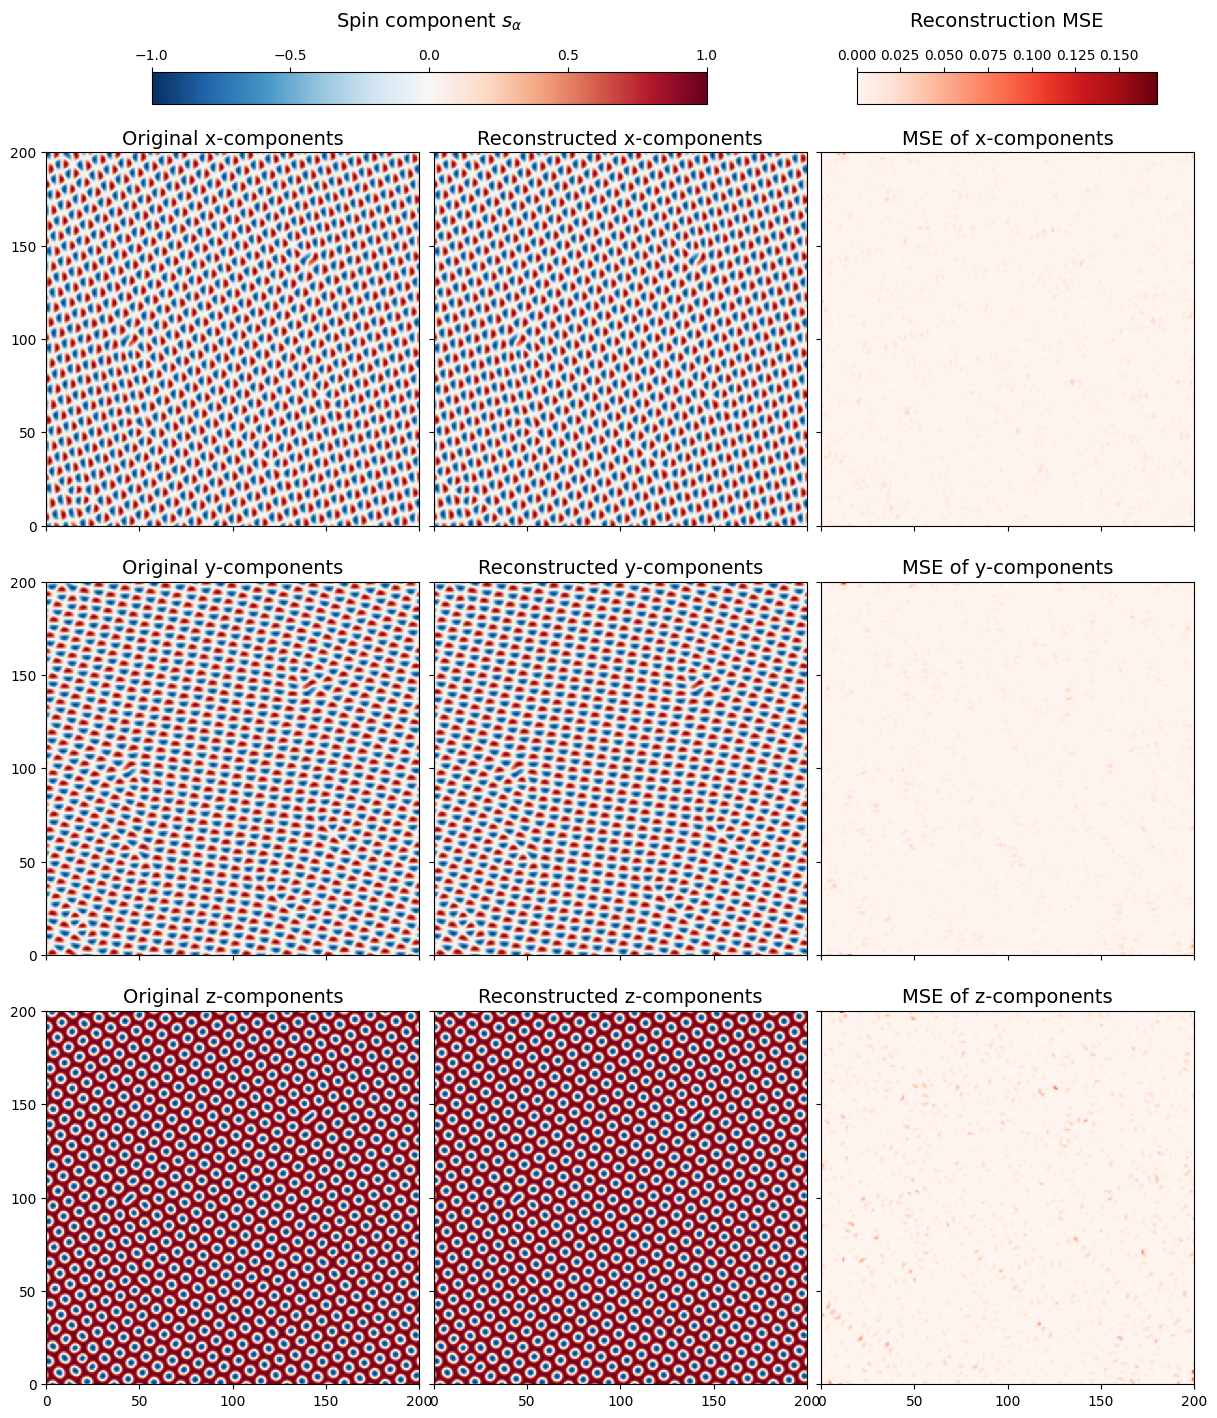

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(15,16), sharex=True, sharey=True)

for coord, coord_name in enumerate("xyz"):
    ImgOrig = X_val[img_index, :, :, coord]  # original image
    ImgRec  = Z_val[img_index, :, :, coord]  # reconstructed  image
        
    im  = axs[coord, 0].imshow(ImgOrig, vmin=-1., vmax=1., cmap="RdBu_r")
    im  = axs[coord, 1].imshow(ImgRec, vmin=-1., vmax=1., cmap="RdBu_r")
    im0 = axs[coord, 2].imshow(RecMSE[:,:,coord], vmin=0., vmax=RecMSE_max, cmap="Reds")
    
    axs[coord, 0].set_title(f"Original {coord_name}-components", fontsize=14)
    axs[coord, 1].set_title(f"Reconstructed {coord_name}-components", fontsize=14)
    axs[coord, 2].set_title(f"MSE of {coord_name}-components", fontsize=14)
    
    for n in range(3):
        axs[coord, n].set_xlim((0, 200))
        axs[coord, n].set_ylim((0, 200))
        axs[coord, n].set_xticks([0,50,100,150,200])
        axs[coord, n].set_yticks([0,50,100,150,200])

# colorbar
cbar = fig.add_axes([0.2, .91, .37, .02])
fig.colorbar(im, cax=cbar, orientation="horizontal", ticks=[-1,-.5, 0., .5, 1.])
cbar.xaxis.set_ticks_position("top")
cbar.set_title(r"Spin component $s_{\alpha}$", fontsize=14, pad=16)

cbar0 = fig.add_axes([0.67, .91, .2, .02])
fig.colorbar(im0, cax=cbar0, orientation="horizontal")
cbar0.xaxis.set_ticks_position("top")
cbar0.set_title(r"Reconstruction MSE", fontsize=14, pad=16)

fig.subplots_adjust(wspace=0, hspace=0.15)

plt.show()

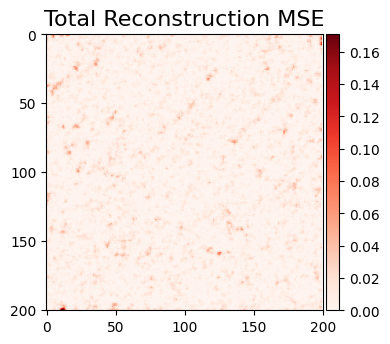

In [22]:
fig, ax = plt.subplots(figsize=(4,4))

I = plt.imshow(np.sum(RecMSE, axis=-1), vmin=0., vmax=RecMSE_max, cmap="Reds")
cbar = fig.colorbar(I, fraction=0.0472, pad=0.01)

ax.set_title("Total Reconstruction MSE", fontsize=16)

ax.set_yticks([0,50,100,150,200])
ax.set_xticks([0,50,100,150,200])

cbar.ax.tick_params(labelsize=10)

fig.tight_layout()

plt.show()

# Local Energies

In [19]:
dB = 0.00426  # magnetic field in the units of J

In [20]:
import tensorflow.experimental.numpy as tnp

In [21]:
def local_energies(X, ind):
    """Get local energies."""
    
    LE = get_local_energies(X[ind:ind+1,:,:,:], 
                            V_val[ind:ind+1, 0], 
                            V_val[ind:ind+1, 1]*dB).numpy()[0]
    
    return LE

In [22]:
LocEnerOrig = local_energies(X_val, img_index)
LocEnerRec  = local_energies(Z_val, img_index)
LocEnerMSE = (LocEnerOrig - LocEnerRec)**2

# calculate minimum and maximum energy in original and reconstructed picture
LocEner_min, LocEner_max = np.min([LocEnerOrig, LocEnerRec]), np.max([LocEnerOrig, LocEnerRec])
LocEnerMSE_min, LocEnerMSE_max = np.min(LocEnerMSE), np.max(LocEnerMSE)

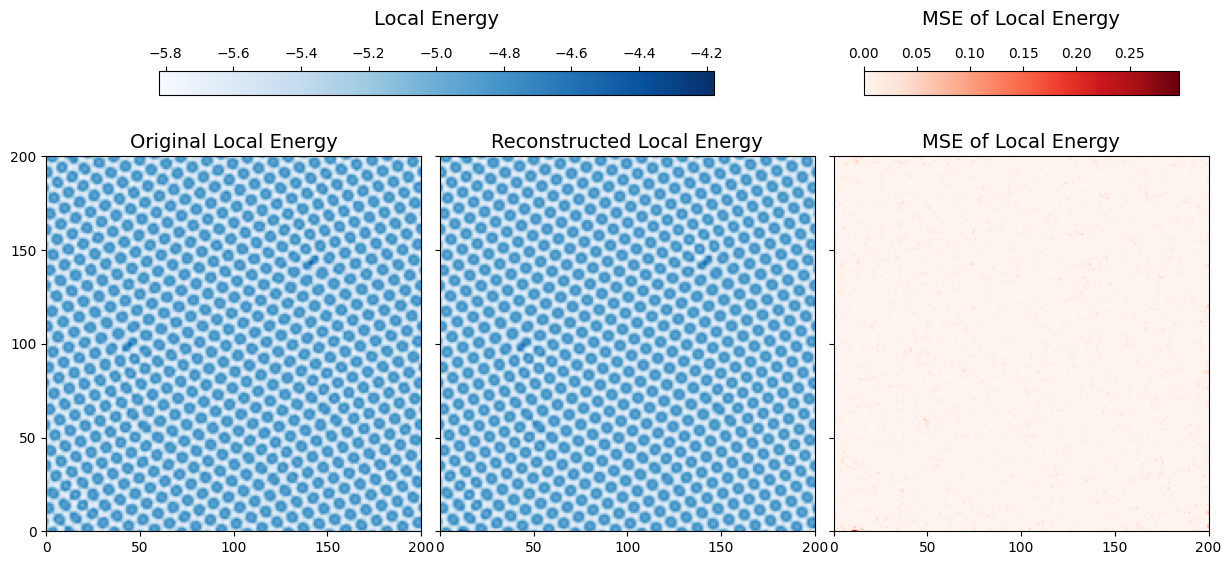

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,6), sharex=True, sharey=True)

im  = axs[0].imshow(LocEnerOrig, vmin=LocEner_min, vmax=LocEner_max, cmap="Blues")
im  = axs[1].imshow(LocEnerRec, vmin=LocEner_min, vmax=LocEner_max, cmap="Blues")
im0 = axs[2].imshow(LocEnerMSE, vmin=0., vmax=LocEnerMSE_max, cmap="Reds")
    
axs[0].set_title(f"Original Local Energy", fontsize=14)
axs[1].set_title(f"Reconstructed Local Energy", fontsize=14)
axs[2].set_title(f"MSE of Local Energy", fontsize=14)
    
for n in range(3):
    axs[n].set_xlim((0, 200))
    axs[n].set_ylim((0, 200))
    axs[n].set_xticks([0,50,100,150,200])
    axs[n].set_yticks([0,50,100,150,200])

# colorbar
cbar = fig.add_axes([0.2, .91, .37, .04])
fig.colorbar(im, cax=cbar, orientation="horizontal")
cbar.xaxis.set_ticks_position("top")
cbar.set_title(r"Local Energy", fontsize=14, pad=16)

cbar0 = fig.add_axes([0.67, .91, .21, .04])
fig.colorbar(im0, cax=cbar0, orientation="horizontal")
cbar0.xaxis.set_ticks_position("top")
cbar0.set_title(r"MSE of Local Energy", fontsize=14, pad=16)
        
fig.subplots_adjust(wspace=0.05, hspace=0.15)

plt.show()

# Local fields

In [24]:
def get_local_fields(Mom, D, B):
    """Calculate local fields for each spin site."""
         
    # get tensors with nearest neightbors (batch_size, 200, 200, 3)
    MR, MU = get_MR(Mom), get_MU(Mom)
    ML, MD = get_ML(Mom), get_MD(Mom)
            
    # local exchange field (batch_size, 200, 200, 3)
    BJ = MR + MU + ML + MD
    
    # local Dzyaloshinskii-Moriya field (batch_size, 200, 200, 3)
    DMI   = get_batch_tensor(D)             # tensor of DMI parameters (batch_size, 200, 200)
    Zeros = tf.zeros((len(Mom), 200, 200))  # tensor of zeros (batch_size, 200, 200)
    
    BD = tf.stack([DMI * MR[:,:,:,2], Zeros, -DMI * MR[:,:,:,0]], axis=-1) + \
         tf.stack([Zeros, -DMI * MU[:,:,:,2], DMI * MU[:,:,:,1]], axis=-1) + \
         tf.stack([-DMI * ML[:,:,:,2], Zeros, DMI * ML[:,:,:,0]], axis=-1) + \
         tf.stack([Zeros, DMI * MD[:,:,:,2], -DMI * MD[:,:,:,1]], axis=-1)
            
    # local Zeeman field (batch_size, 200, 200, 3)        
    BZ = tf.stack([Zeros, Zeros,  tf.ones_like(Zeros)*get_batch_tensor(B)], axis=-1) # my fix, added the tf.ones_like(Zeros)*, my new get_batch_tensor(B) did not broadcast here
    
    return BJ + BD + BZ

In [25]:
def local_fields(X, ind):
    """Get local field magnitude."""
    
    LF = get_local_fields(X[ind:ind+1,:,:,:], 
                          V_val[ind:ind+1, 0], 
                          V_val[ind:ind+1, 1]*dB).numpy()[0]
    
    LFmag = np.sqrt(np.sum(LF**2, axis=-1))
    
    return np.sum(X[ind] * LF, axis=-1) / LFmag

In [26]:
LocFieldOrig = local_fields(X_val, img_index)
LocFieldRec  = local_fields(Z_val, img_index)

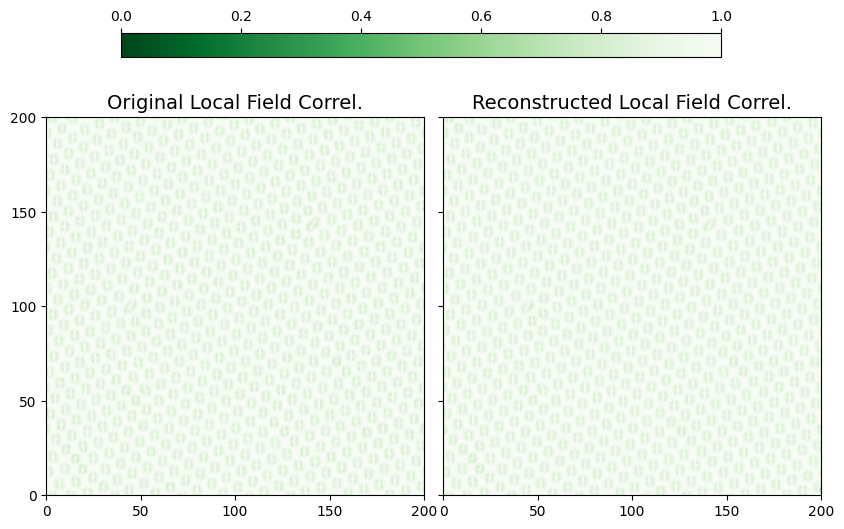

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,6), sharex=True, sharey=True)

for coord, coord_name in enumerate("xyz"):
    im  = axs[0].imshow(LocFieldOrig, vmin=0., vmax=1, cmap="Greens_r")
    im  = axs[1].imshow(LocFieldRec, vmin=0., vmax=1., cmap="Greens_r")
    
    axs[0].set_title(f"Original Local Field Correl.", fontsize=14)
    axs[1].set_title(f"Reconstructed Local Field Correl.", fontsize=14)
    
    for n in range(2):
        axs[n].set_xlim((0, 200))
        axs[n].set_ylim((0, 200))
        axs[n].set_xticks([0,50,100,150,200])
        axs[n].set_yticks([0,50,100,150,200])

# colorbar
cbar_ax = fig.add_axes([0.2, .91, .6, .04])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.set_label(r"angle $\theta$")
        
fig.subplots_adjust(wspace=0.05, hspace=0.15)

plt.show()

# Boundary conditions

In [28]:
def get_boundary_exch_energy(X, n):
    """Exchange energy at the boundaries."""
    
    return np.sum(X[n,0,:,:] * X[n,-1,:,:] + X[n,:,0,:] * X[n,:,-1,:])

In [29]:
EBoundOrig = get_boundary_exch_energy(X_val, img_index)
EBoundRec  = get_boundary_exch_energy(Z_val, img_index)

EBoundOrig, EBoundRec

(339.0332, 330.36206)